In [ ]:
# Installe le client Kaggle
!pip -q install kaggle

# Uploader le fichier depuis ton ordi
from google.colab import files
uploaded = files.upload()  # ici, tu choisis le fichier kaggle.json

# Mettre le fichier au bon endroit, définir les permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Télécharger le dataset
!mkdir -p /content/data
!kaggle datasets download -d puneet6060/intel-image-classification -p /content/data

# Dézipper
import glob, os
zips = glob.glob('/content/data/*.zip')
assert len(zips) > 0, "Zip non trouvé. Vérifie que le download a bien fonctionné."
zip_path = zips[0]
!unzip -q "$zip_path" -d /content/data


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 90% 310M/346M [00:00<00:00, 596MB/s]
100% 346M/346M [00:00<00:00, 546MB/s]


In [ ]:
# === Dézipper (si pas déjà fait) ===
import glob, os, pathlib, zipfile

zips = glob.glob('/content/data/*.zip')
if zips:
    zip_path = zips[0]
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall('/content/data')

# === Vérifier l’arborescence ===
!find /content/data -maxdepth 2 -type d -print


/content/data
/content/data/seg_test
/content/data/seg_test/seg_test
/content/data/seg_train
/content/data/seg_train/seg_train
/content/data/seg_pred
/content/data/seg_pred/seg_pred


In [ ]:
import tensorflow as tf
from pathlib import Path

# Adapte  chemins si cellule précédente montre autre chose
train_dir = Path("/content/data/seg_train/seg_train")
test_dir  = Path("/content/data/seg_test/seg_test")

IMG_SIZE = (160, 160)   # bon pour MobileNetV2
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, validation_split=0.2, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, validation_split=0.2, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.class_names
print("Classes:", class_names)

# Optimisations pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
], name="data_aug")


In [ ]:
from tensorflow.keras import layers, models, applications, optimizers

num_classes = len(class_names)

# Backbone pré-entraîné ImageNet
backbone = applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
backbone.trainable = False  # étape 1 : on gèle

# Modèle "étudiant SI"
inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = backbone(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# Callbacks
cb_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True)
cb_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "mobilenetv2_freeze.keras", monitor="val_accuracy", save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,              # rapide et suffisant pour une bonne baseline
    callbacks=[cb_early, cb_ckpt]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 289s 787ms/step - accuracy: 0.7760 - loss: 0.6128 - val_accuracy: 0.9020 - val_loss: 0.2587
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 352s 876ms/step - accuracy: 0.8781 - loss: 0.3207 - val_accuracy: 0.9009 - val_loss: 0.2622
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 296s 819ms/step - accuracy: 0.8847 - loss: 0.2965 - val_accuracy: 0.9098 - val_loss: 0.2366
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 302s 769ms/step - accuracy: 0.9002 - loss: 0.2741 - val_accuracy: 0.9098 - val_loss: 0.2315
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 277s 772ms/step - accuracy: 0.8977 - loss: 0.2697 - val_accuracy: 0.9113 - val_loss: 0.2272


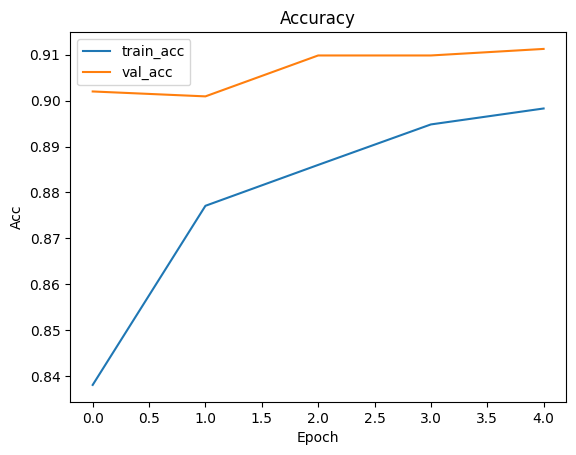

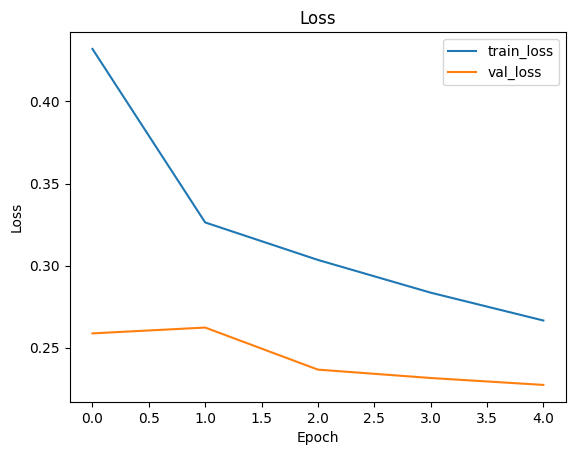

In [ ]:
import matplotlib.pyplot as plt

def plot_history(h):
    hist = h.history
    # accuracy
    plt.figure()
    plt.plot(hist['accuracy'], label='train_acc')
    plt.plot(hist['val_accuracy'], label='val_acc')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend(); plt.show()
    # loss
    plt.figure()
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plot_history(history)


Test accuracy: 0.909
              precision    recall  f1-score   support

   buildings       0.88      0.93      0.91       437
      forest       0.99      1.00      0.99       474
     glacier       0.89      0.80      0.84       553
    mountain       0.84      0.88      0.86       525
         sea       0.93      0.97      0.95       510
      street       0.94      0.90      0.92       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



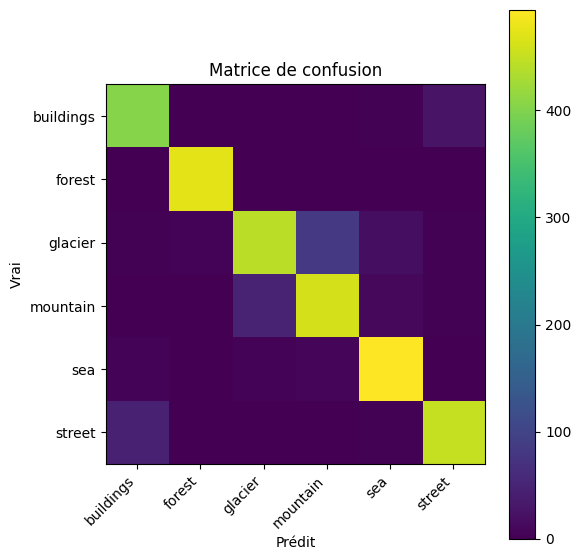

In [ ]:
import numpy as np
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")

# Prédictions
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds, verbose=0)
y_pred = y_pred_probs.argmax(axis=1)

# Rapport + matrice
!pip -q install scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot matrice
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Matrice de confusion")
plt.xlabel("Prédit"); plt.ylabel("Vrai")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)
plt.colorbar(); plt.tight_layout(); plt.show()

# Sauvegarde du modèle
model.save("scene_classifier.keras")


In [ ]:
# Dégeler partiellement les ~40 dernières couches
backbone.trainable = True
fine_tune_from = len(backbone.layers) - 40
for i, layer in enumerate(backbone.layers):
    layer.trainable = (i >= fine_tune_from)

model.compile(optimizer=optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

cb_early2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True)
history_ft = model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=[cb_early2])


Epoch 1/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step - accuracy: 0.7591 - loss: 0.7186 - val_accuracy: 0.9056 - val_loss: 0.2544
Epoch 2/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.8569 - loss: 0.3749 - val_accuracy: 0.9155 - val_loss: 0.2303
Epoch 3/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.8782 - loss: 0.3277 - val_accuracy: 0.9195 - val_loss: 0.2234


In [ ]:
for layer in model.layers:
    print(layer.name, type(layer))


input_layer_1 <class 'keras.src.layers.core.input_layer.InputLayer'>
data_aug <class 'keras.src.models.sequential.Sequential'>
rescaling <class 'keras.src.layers.preprocessing.rescaling.Rescaling'>
mobilenetv2_1.00_160 <class 'keras.src.models.functional.Functional'>
global_average_pooling2d <class 'keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>
dropout <class 'keras.src.layers.regularization.dropout.Dropout'>
dense <class 'keras.src.layers.core.dense.Dense'>
dense_1 <class 'keras.src.layers.core.dense.Dense'>


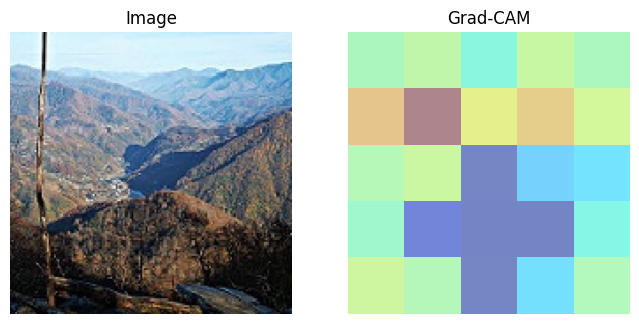

block_16_expand_BN
block_16_expand_relu
block_16_depthwise
block_16_depthwise_BN
block_16_depthwise_relu
block_16_project
block_16_project_BN
Conv_1
Conv_1_bn
out_relu


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow import keras

def make_gradcam_heatmap(img_tensor, full_model, backbone_name="mobilenetv2_1.00_160", layer_name="out_relu", pred_index=None):
    # Récupérer le backbone (MobileNetV2)
    backbone = full_model.get_layer(backbone_name)

    # Nouveau modèle : input backbone -> (feature maps, output global)
    conv_layer = backbone.get_layer(layer_name).output
    grad_model = keras.Model(inputs=backbone.input, outputs=[conv_layer, backbone.output])

    # Passer par le backbone seulement
    with tf.GradientTape() as tape:
        conv_outputs, features = grad_model(img_tensor)
        # On repasse par la tête du modèle global
        pooled = tf.reduce_mean(features, axis=(1,2))  # GAP comme dans le modèle
        x = full_model.layers[-3](pooled)   # dense(128, relu)
        x = full_model.layers[-2](x)        # dense finale
        preds = full_model.layers[-1](x)    # softmax sortie

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap)+1e-8)
    return heatmap.numpy()

# === Exemple sur une image test ===
img_path = str(list((test_dir / "mountain").glob("*"))[0])
pil = load_img(img_path, target_size=IMG_SIZE)
arr = img_to_array(pil)
arr = np.expand_dims(arr, 0)  # (1,H,W,3)
# Pas de /255 : le modèle a déjà un Rescaling

heatmap = make_gradcam_heatmap(tf.convert_to_tensor(arr, dtype=tf.float32), model)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(pil); plt.axis("off"); plt.title("Image")
plt.subplot(1,2,2); plt.imshow(pil)
plt.imshow(heatmap, cmap="jet", alpha=0.45)
plt.axis("off"); plt.title("Grad-CAM")
plt.show()


for l in model.get_layer("mobilenetv2_1.00_160").layers[-10:]:
    print(l.name)
